In [80]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import qutip
import theano
import theano.tensor as T
from collections import OrderedDict
import itertools
import os
import sys

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

from qubit_network.QubitNetwork import QubitNetwork
import qubit_network as qn
from qubit_network.net_analysis_tools import *

from utils import *

pairs = list(itertools.combinations(range(4), 2))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Half-adder gate
The half-adder gate is a toffoli gate, followed by a CNOT gate between first and third qubit.

The first two input qubits are the inputs to be summed, the second output qubit is the (half) sum, the third output qubit the carrier, and the first output qubit is ancillary.

<IPython.core.display.Javascript object>


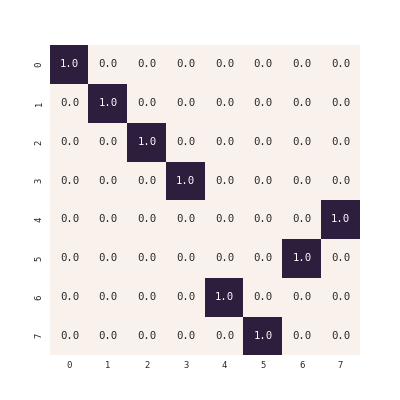

In [111]:
halfadder = (qutip.cnot(3, 0, 1) * qutip.toffoli())

f, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(halfadder.data.toarray().real,
                square=True, annot=True, fmt='1.1f', cbar=False)

### A Fredkin gate is be obtained with very good fidelity, $\simeq 99.999\%$, starting with all interactions on, and only $\sigma_z$ operators as self-interactions.

Generating training data...
Building the model...
Let's roll!


<IPython.core.display.Javascript object>


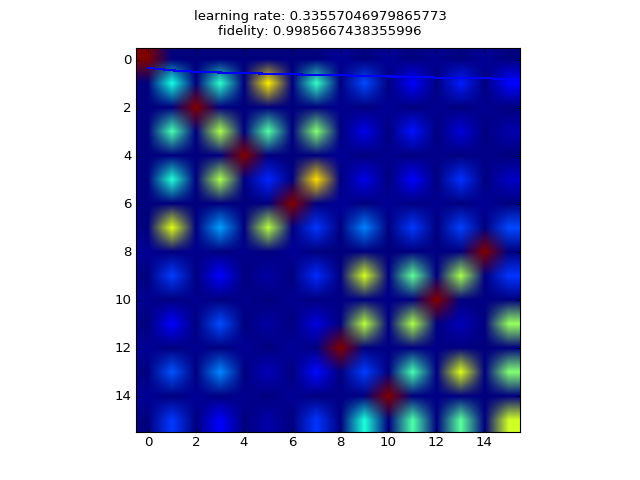

Finished training
Final fidelity: 0.9989482001503172


In [44]:
net = QubitNetwork(
    num_qubits=4,
    system_qubits=3,
    interactions='all'
#     J=new_Jvalues
)
qn.sgd_optimization(
    net=net,
    learning_rate=1,
    n_epochs=200,
    batch_size=10,
    target_gate=halfadder,
    training_dataset_size=100,
    test_dataset_size=1000,
    decay_rate=.01
#     saveafter_file='nets/fredkin_best.pickle'
)

In [46]:
net.save_to_file('../data/nets/halfadder_3q+1a_all_f9989')

### Reload net from file and test fidelity

In [140]:
net = qn.load_network_from_file('../data/nets/halfadder_3q+1a_all_f998')
print('Fidelity: {}'.format(net.test_fidelity(n_samples=1000)))

Fidelity: 0.9985211789889469


### From the training above, many elements resulted to be extremely small/vanishing:

In [188]:
# import pandas
vanishing_interactions = vanishing_elements(net)
# vanishing_interactions = [list(elem) for elem in vanishing_interactions]
# pandas.DataFrame([str(item) for item in vanishing_interactions])
pandas.DataFrame(transpose(vanishing_interactions))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3,3,"(0, 3)","(0, 3)","(0, 3)","(0, 3)","(0, 3)","(0, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(2, 3)","(2, 3)","(2, 3)","(2, 3)","(2, 3)","(2, 3)"
1,x,y,xx,xy,yx,yy,zx,zy,xx,xy,yx,yy,zx,zy,xx,xy,yx,yy,zx,zy


### Let's see the non-vanishing ones:

In [192]:
# print_OrderedDict(net.get_interactions_with_Js())
nonvanishing_interactions = []
for k, v in net.get_interactions_with_Js().items():
    if k not in vanishing_interactions:
        nonvanishing_interactions.append((k, v))
nonvanishing_interactions

[((0, 'x'), 0.47935971788634213),
 ((0, 'y'), 0.12463306433346917),
 ((0, 'z'), 4.3327800146468807),
 ((1, 'x'), -0.20901929006023617),
 ((1, 'y'), 0.18745010237645462),
 ((1, 'z'), -0.29176989060805214),
 ((2, 'x'), 1.4310623386359607),
 ((2, 'y'), -0.90272095082382287),
 ((2, 'z'), 0.51511730673320821),
 ((3, 'z'), 0.63609397016806357),
 (((0, 1), 'xx'), 0.38987923962985221),
 (((0, 1), 'xy'), -0.36259500039902426),
 (((0, 1), 'xz'), -0.16140882883715219),
 (((0, 1), 'yx'), -0.19137544423116915),
 (((0, 1), 'yy'), 0.16554094336167385),
 (((0, 1), 'yz'), -0.36281113233722401),
 (((0, 1), 'zx'), -2.9938922633897298),
 (((0, 1), 'zy'), 2.9527098900696247),
 (((0, 1), 'zz'), -0.1104254646768969),
 (((0, 2), 'xx'), 0.39536959408066619),
 (((0, 2), 'xy'), -0.0068736539115307974),
 (((0, 2), 'xz'), -0.0071210995111951059),
 (((0, 2), 'yx'), -0.19479082716256324),
 (((0, 2), 'yy'), 0.0068880731498788964),
 (((0, 2), 'yz'), -0.0077647614643308483),
 (((0, 2), 'zx'), -3.2614138052747084),
 (((

### The unitary representing the evolution in the total space can be easily understood rearranging the bases, putting the ancillary space as the first one.

Here is the original unitary in the 3+1 qubits space:

<IPython.core.display.Javascript object>


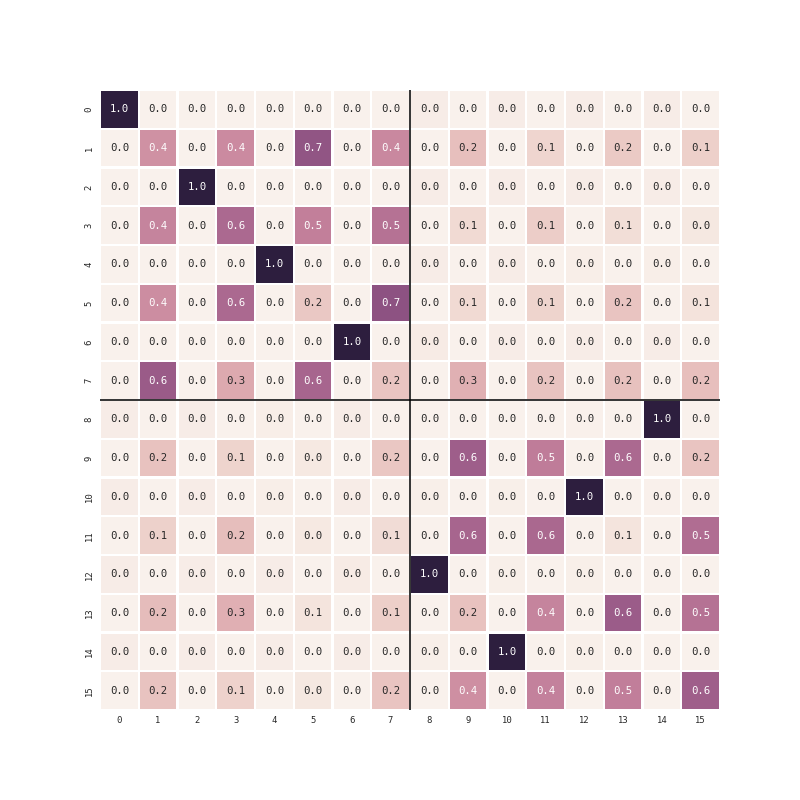

In [116]:
obtained_halfadder = normalize_phase(net.get_current_gate()).data.toarray()

# plt.imshow(abs(obtained_halfadder))
sns.set(context="paper", font="monospace")

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(abs(obtained_halfadder),
                 square=True, annot=True, fmt='1.1f', linewidth=1, cbar=False)
ax.hlines([8], *ax.get_xlim())
ax.vlines([8], *ax.get_ylim())

And here is the one with the ancilla as first qubit:

<IPython.core.display.Javascript object>


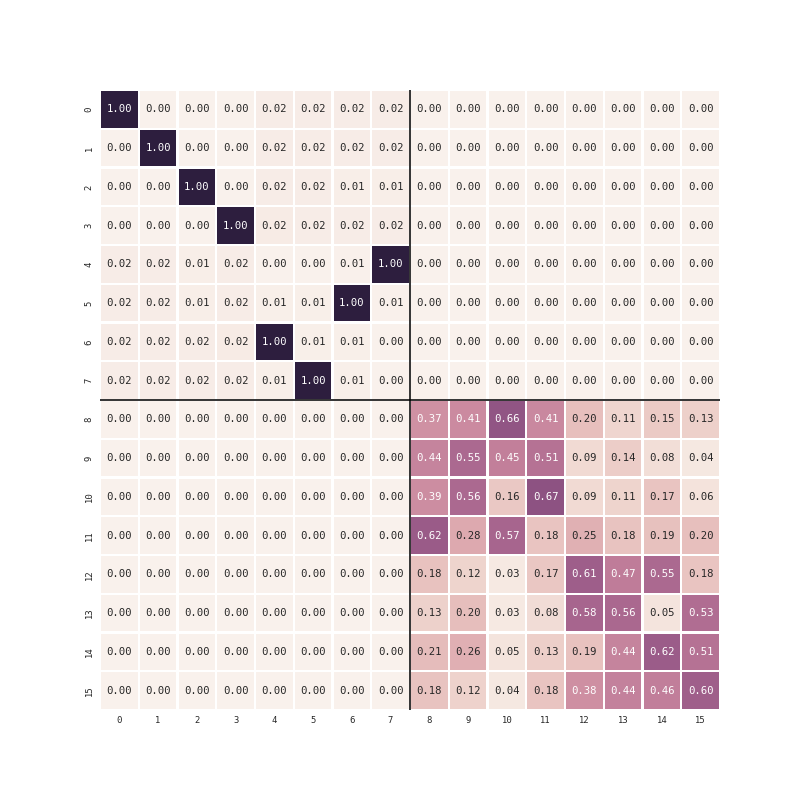

In [193]:
obtained_halfadder = normalize_phase(net.get_current_gate())
obtained_halfadder = obtained_halfadder.permute([3, 0, 1, 2])
obtained_halfadder = obtained_halfadder.data.toarray()

# plt.imshow(abs(obtained_halfadder))
sns.set(context="paper", font="monospace")

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(abs(obtained_halfadder),
                 square=True, annot=True, fmt='1.2f', linewidth=1, cbar=False)
ax.hlines([8], *ax.get_xlim())
ax.vlines([8], *ax.get_ylim())